In [10]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import copy
from collections import deque

In [11]:
def vwap_strat1(df, dates):  # good
    # Calculate T_last_close and T_vap (VWAP)
    last_closes = [
        df.loc[date]["Close"].iloc[-1] for date in dates
    ]
    vwaps = [
        (df.loc[date]["Close"] * df.loc[date]["Volume"]).sum() /
        df.loc[date]["Volume"].sum()
        for date in dates
    ]

    # if the last close price is higher than VWAP (T_vap), sell (-1), otherwise buy (+1)
    ratio = np.array(last_closes) / np.array(vwaps)
    return ratio

def amplitude_strat(df, dates):  # ok
    amplitude = [
        (df.loc[date]["High"].max() - df.loc[date]["Low"].min()) / df.loc[date]["Open"].iloc[0]
        for date in dates
    ]
    return np.array(amplitude)

def close_pos_strat1(df, dates):  # good
    pos = [
        (df.loc[date]["Close"].iloc[-1] - df.loc[date]["Low"].min()) /
        (df.loc[date]["High"].max() - df.loc[date]["Low"].min() + 1e-9)
        for date in dates
    ]
    return np.array(pos)

def reversal_strat(df, dates):  # ok
    opens = [df.loc[date]["Open"].iloc[0] for date in dates]
    closes = [df.loc[date]["Close"].iloc[-1] for date in dates]
    rev = np.array(closes) - np.array(opens)
    return rev

def momentum_strat2(df, dates, end_length=45):
    mom = [
        (df.loc[date]['Close'].iloc[-1] - df.loc[date]['Open'].iloc[-end_length]) /
        df.loc[date]['Open'].iloc[-end_length]
        for date in dates
    ]
    return np.array(mom)

def liquidity_strat(df, dates, window=10):
    volumes = [df.loc[date]["Volume"].sum() for date in dates]
    rets = [
        (df.loc[date]["Close"].iloc[-1] - df.loc[date]["Open"].iloc[0]) /
        df.loc[date]["Open"].iloc[0]
        for date in dates
    ]
    rvol = pd.Series(volumes) / pd.Series(volumes).rolling(window).mean()

    factor = []
    for r, rv in zip(rets, rvol):
        if np.isnan(rv):  # warmup periods
            factor.append(0.0)
            continue
        if rv < 0.9: # opposite sign of r, weighted by fragility
            factor.append(-r * np.log(1 + 1/rv))
        else: # return * rv (so high-volume moves get more weight)
            factor.append(r * rv)

    return np.array(factor)

def vwap_strat3(df, dates):
    rets = [
        (df.loc[date]["Close"].iloc[-1] - df.loc[date]["Open"].iloc[0]) / df.loc[date]["Open"].iloc[0]
        for date in dates
    ]
    amounts = [df.loc[date]['Amount'].mean() for date in dates]
    adv20 = pd.Series(amounts).rolling(20).mean().values
    vwaps = [
        (df.loc[date]["Close"] * df.loc[date]["Volume"]).sum() / df.loc[date]["Volume"].sum()
        for date in dates
    ]
    highs = [df.loc[date]['High'].max() for date in dates]
    closes = [df.loc[date]['Close'].iloc[-1] for date in dates]

    factor = -np.array(rets) * adv20 * np.array(vwaps) * (np.array(highs) - np.array(closes))
    return factor

In [12]:
FIBONNACCI = [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 239]
PRIMITIVES = {
    "vwap_strat1": vwap_strat1,
    "close_pos_strat1": close_pos_strat1,
    "momentum_strat2": momentum_strat2,
    "vwap_strat3": vwap_strat3,
    "reversal_strat": reversal_strat,
    "liquidity_strat": liquidity_strat,
    "amplitude_strat": amplitude_strat,
}

In [13]:
class stock_info:
    def __init__(self, filepath, target_col):
        # Load data from HDF file
        self.raw = pd.read_hdf(filepath, mode="r", key="d")
        
        # Extract the target column i.e "IC"
        self.target_raw = self.raw[target_col]
        
        # Get the list of dates
        self.dates = self.target_raw.index.tolist()
        
        # initiate a new dataframe recording daily return 
        self.readouts = pd.DataFrame(self.dates, columns=["dates"])
        self.readouts.set_index("dates", inplace=True)

    def evaluate_return_T_p1(self, t_exec, strategy_array_name):
        # read strategy for T+1
        strategy_ = np.array(self.readouts[strategy_array_name].tolist()[:-2])
        
        # read close price at specified time in T+1 and T+2 respectively
        short_price_T_p1 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[1:-1]])
        long_price_T_p2 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[2:]])
        
        # calculate return rate at T+1
        return_rate_T_p1 = pd.Series(((long_price_T_p2/short_price_T_p1)-1.)*strategy_, index=self.dates[:-2])
        
        # append to self.readouts
        self.readouts["return_"+strategy_array_name+"_"+str(t_exec)] = return_rate_T_p1

    def get_sharpe_ratio(self, strategy_name, t):
        strategy_return="return_"+strategy_name+"_"+str(t)

        # obtain return rate under specified strategy
        return_arr = self.readouts[strategy_return].tolist()[:-2]
        
        # calculate traditional sharpe ratio
        sharpe_ratio = np.sqrt(250.)*np.mean(return_arr)/np.std(return_arr)

        return sharpe_ratio
    
    def get_win_rate(self, strategy_return):
        return_arr = self.readouts[strategy_return].dropna()

        win_rate = (return_arr > 0).mean()
        return win_rate

    def generate_time_dependency(self, times, strategy_array_name):
        sharpe_arr = []
        win_rate_arr = []
        
        for t_exec in times:
            # calculate return rate of combinations of strategy with different trading times
            self.evaluate_return_T_p1(t_exec, strategy_array_name=strategy_array_name)
            # record metrics
            sharpe_arr.append(self.get_sharpe_ratio(strategy_array_name, t_exec))
            win_rate_arr.append(self.get_win_rate(strategy_return="return_"+strategy_array_name+"_"+str(t_exec)))
            
        return sharpe_arr, win_rate_arr

In [14]:
def plot_metric(x_arr, y_arr, label, critical_val, xlabel="Trading Time (min)", title="Time Sensitivity of "):
    plt.figure()

    plt.plot(x_arr, y_arr, marker="o", label=label)
    plt.axhline(y=critical_val, color="red", linestyle="--", linewidth=1, label="baseline")
    
    plt.title(title + label)
    plt.xlabel(xlabel)
    plt.ylabel(label)
    
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()

In [15]:
def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    if s.isna().all():
        return s

    low = s.quantile(lower_q)
    high = s.quantile(upper_q)
    return s.clip(lower=low, upper=high)

class AlphaNode:
    NAMESPACE = {
        "add": lambda a, b: a + b,
        "sub": lambda a, b: a - b,
        "mul": lambda a, b: a * b,
        "div": lambda a, b: np.divide(a, b + 1e-6, out=np.zeros_like(a), where=b!=0),
        "square_diff": lambda a, b: a**2 - b**2,

        "log1p_abs": lambda a: np.log1p(np.abs(a)),
        "sqrt_abs": lambda a: np.sqrt(np.abs(a)),
        "tanh": np.tanh,
        "zscore": lambda a: (a - np.nanmean(a)) / (np.nanstd(a) + 1e-6),
        "lag1": lambda a: np.roll(a, 1),
        "diff": lambda a: pd.Series(a).diff().fillna(0).values,
        "rolling_mean_5": lambda a: pd.Series(a).rolling(5, min_periods=1).mean().values,
    }

    def __init__(self, val, left=None, right=None, param=None):
        self.val = val
        self.left = left
        self.right = right
        self.param = param

    def get_formula(self):
        if self.val in PRIMITIVES:  # feature leaf
            return f"{self.val}(df, dates)"

        elif self.val in self.NAMESPACE and self.right:  # binary op
            return f"{self.val}({self.left.get_formula()}, {self.right.get_formula()})"

        elif self.val in self.NAMESPACE:  # unary op
            return f"{self.val}({self.left.get_formula()})"

        else:
            raise ValueError(f"Unknown operation {self.val}")

    def evaluate(self, df, dates):
        formula = self.get_formula()
        namespace = dict(self.NAMESPACE)
        namespace.update(PRIMITIVES)
        namespace["df"] = df
        namespace["dates"] = dates
        result = eval(formula, namespace)
        return winsorize_series(pd.Series(result)).values

    def get_height(self):
        if not self.left and not self.right:
            return 1

        return 1 + max(self.left.get_height() if self.left else 0,
                       self.right.get_height() if self.right else 0)

In [ ]:
def random_alpha_tree(max_depth=3, leaf_threshold=0.2):
    # Base case: primitive strat
    if max_depth == 0 or (max_depth > 1 and random.random() < leaf_threshold):
        return AlphaNode(random.choice(list(PRIMITIVES.keys())))

    if random.random() < 0.5:  # unary op
        op = random.choice(["log1p_abs", "sqrt_abs", "tanh", "zscore", "lag1", "diff", "rolling_mean_5"])
        return AlphaNode(op, left=random_alpha_tree(max_depth - 1, leaf_threshold))
    else:  # binary op
        op = random.choice(["add", "sub", "mul", "div", "square_diff"])
        left, right = random_alpha_tree(max_depth - 1, leaf_threshold), random_alpha_tree(max_depth - 1, leaf_threshold)
        return AlphaNode(op, left, right)

def mutate(node: AlphaNode, mutation_rate=0.2, max_depth=3):
    if max_depth <= 0:
        return node

    if random.random() < mutation_rate:
        return random_alpha_tree(max_depth)

    if node.left:
        node.left = mutate(node.left, mutation_rate, max_depth - 1)
    if node.right:
        node.right = mutate(node.right, mutation_rate, max_depth - 1)

    return node

def crossover(p1: AlphaNode, p2: AlphaNode) -> AlphaNode:
    """Swap a random subtree of p1 with a random subtree of p2."""
    depth1 = random.randint(0, p1.get_height() - 1)
    depth2 = random.randint(0, p2.get_height() - 1)

    if depth1 == 0:
        return p2  # replace entire tree

    def get_level_nodes(root: AlphaNode, l: int):
        if not root:
            return []
        
        nodes = []
        queue = deque([(root, None, 0)])  # (node, parent, depth)

        while queue:
            curr, parent, depth = queue.popleft()

            if depth == l:
                nodes.append((curr, parent))
            elif depth < l:
                if curr.left:
                    queue.append((curr.left, curr, depth + 1))
                if curr.right:
                    queue.append((curr.right, curr, depth + 1))

        return nodes

    p1_subtree, p1_parent = random.choice(get_level_nodes(p1, depth1))
    p2_subtree, _ = random.choice(get_level_nodes(p2, depth2))

    if p1_parent.left is p1_subtree:
        p1_parent.left = p2_subtree
    else:
        p1_parent.right = p2_subtree

    return p1

def fitness(strat, backtester, times = FIBONNACCI):
    sharpes, _ = backtester.generate_time_dependency(times, strat)
    max_sharpe = max(sharpes)
    max_sharpe_index = sharpes.index(max_sharpe)
    return max_sharpe, times[max_sharpe_index]

def get_signal(factors: np.array, window: int = 20):
    s = pd.Series(factors)

    rolling_mean = s.rolling(window, min_periods=5).mean()
    rolling_std = s.rolling(window, min_periods=5).std()

    # rolling z-score, then squash into [-1,1] with tanh
    normalized_factor = np.tanh((s - rolling_mean) / (rolling_std + 1e-8))

    return normalized_factor.ffill().bfill().values, -normalized_factor.ffill().bfill().values

def evolve(backtester, n_generations=8, pop_size=20, retain=0.3, mutation_rate=0.3):
    df, dates = backtester.target_raw, backtester.dates
    population = [random_alpha_tree() for _ in range(pop_size)]

    for gen in range(n_generations):
        scores = []
        for i, alpha in enumerate(population):
            try:
                factors = alpha.evaluate(df, dates)
                signals1, signals2 = get_signal(factors)

                strat_name1, strat_name2 = f"alpha_{gen}_{i}_follow", f"alpha_{gen}_{i}_rev"
                backtester.readouts[strat_name1] = pd.Series(signals1, index=dates)
                backtester.readouts[strat_name2] = pd.Series(signals2, index=dates)

                score1, best_t1 = fitness(strat_name1, backtester)
                score2, best_t2 = fitness(strat_name2, backtester)
                if np.isnan(score1):
                    print(alpha.get_formula(), backtester.readouts[strat_name1])

                del backtester.readouts[strat_name1]
                del backtester.readouts[strat_name2]
            except Exception:
                scores.append((-999, None, alpha, "N/A"))
                continue

            scores.append((score1, best_t1, alpha, "trend")) if score1 >= score2 else scores.append((score2, best_t2, alpha, "reversal"))

        scores.sort(key=lambda x: x[0], reverse=True)
        best_score, best_t, best_alpha, _ = scores[0]
        print(scores)
        print(f"Gen {gen+1}: Best Sharpe={best_score:.3f} at t_exec={best_t}")

        retain_length = int(len(scores) * retain)
        survivors = [alpha for _, _, alpha, _ in scores[:retain_length]]

        # Generate offspring
        offspring = []
        while len(survivors) + len(offspring) < pop_size:
            if random.random() < 0.5 and len(survivors) >= 2:
                p1, p2 = random.sample(survivors, 2)
                child = crossover(copy.deepcopy(p1), copy.deepcopy(p2))
            else:
                p = random.choice(survivors)
                child = mutate(copy.deepcopy(p), mutation_rate)
            offspring.append(child)

        population = survivors + offspring

    return scores

In [17]:
mydata = stock_info("MinutesIdx.h5", "IC")
result = evolve(mydata)

/tmp/ipykernel_1700/1649278639.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.readouts["return_"+strategy_array_name+"_"+str(t_exec)] = return_rate_T_p1
/tmp/ipykernel_1700/1934860264.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  backtester.readouts[strat_name1] = pd.Series(signals1, index=dates)
/tmp/ipykernel_1700/1934860264.py:100: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

[(1.2173596639550965, 55, <__main__.AlphaNode object at 0xf1657ce0a2b0>, 'reversal'), (1.1826714151049438, 55, <__main__.AlphaNode object at 0xf1657cde4880>, 'reversal'), (1.1672149470941857, 55, <__main__.AlphaNode object at 0xf1657ce0a4f0>, 'reversal'), (1.1273984745017767, 55, <__main__.AlphaNode object at 0xf1657ce0a2e0>, 'reversal'), (0.9715208177937642, 55, <__main__.AlphaNode object at 0xf1657ce7f2b0>, 'reversal'), (0.8865778830353716, 89, <__main__.AlphaNode object at 0xf1657ce0a130>, 'trend'), (0.8011637332139533, 34, <__main__.AlphaNode object at 0xf1657cde4ca0>, 'reversal'), (0.7265953837457232, 55, <__main__.AlphaNode object at 0xf1657e6e1e80>, 'trend'), (0.6987312778896292, 34, <__main__.AlphaNode object at 0xf1657ce0a190>, 'reversal'), (0.6539876434445929, 0, <__main__.AlphaNode object at 0xf1657eae3ca0>, 'trend'), (0.6539876434445929, 0, <__main__.AlphaNode object at 0xf1657ce99d00>, 'trend'), (0.5179567610406826, 13, <__main__.AlphaNode object at 0xf1657ce0adf0>, 'rever

Alpha Formula: zscore(add(div(liquidity_strat(df, dates), liquidity_strat(df, dates)), tanh(close_pos_strat1(df, dates))))


/tmp/ipykernel_1700/1685204064.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  mydata.readouts['best_alpha'] = get_signal(factors)[1] if best_alpha[-1] == 'reversal' else get_signal(factors)[0]
/tmp/ipykernel_1700/1649278639.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.readouts["return_"+strategy_array_name+"_"+str(t_exec)] = return_rate_T_p1


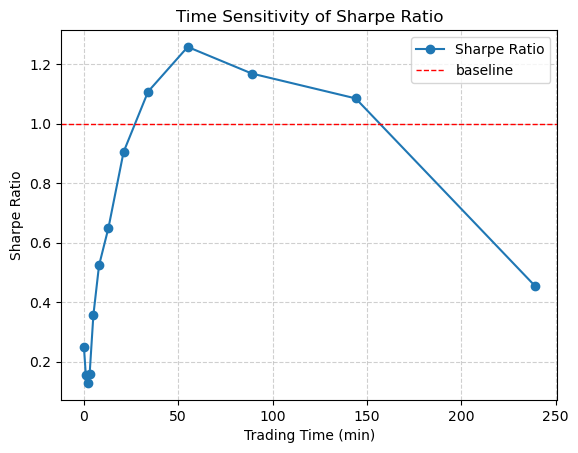

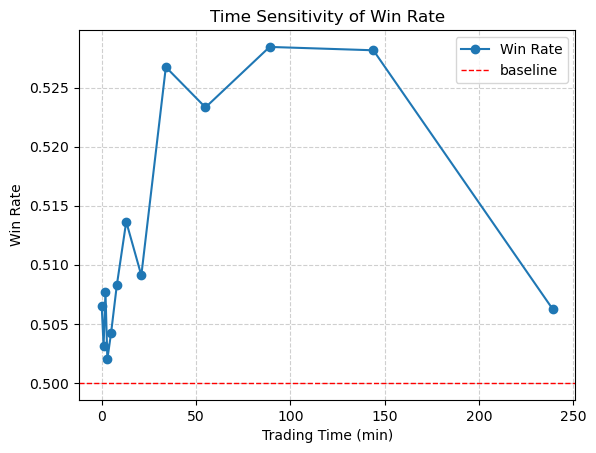

In [18]:
best_alpha = result[1]
print("Alpha Formula: " + best_alpha[2].get_formula())

factors = best_alpha[2].evaluate(mydata.target_raw, mydata.dates)

mydata.readouts['best_alpha'] = get_signal(factors)[1] if best_alpha[-1] == 'reversal' else get_signal(factors)[0]

sharpe_sensitivity, win_rate_sensitivity = mydata.generate_time_dependency(FIBONNACCI, 'best_alpha')
plot_metric(FIBONNACCI, sharpe_sensitivity, "Sharpe Ratio", 1)
plot_metric(FIBONNACCI, win_rate_sensitivity, "Win Rate", 0.5)